# Building an Intake-esm catalog from CESM2 History Files

In this example, we will cover how to build a data catalog from Community Earth System Model (CESM) output. One of the requirements for using intake-esm is having a catalog which is comprised of two pieces:
* A table of the relevant metadata (ex. file path, variable, stream, etc.)
* A json describing the dataset, including how to aggregate the variables

Typically, these pieces are constructed "manually" using information within the file path, on a very ad-hoc basis. Also, these catalogs are typically only created for "larger", community datasets, not neccessarily used within smaller model runs/daily workflows. A new package (currently a prototype), called [ecgtools](https://ecgtools.readthedocs.io/en/latest/) works to solve the issues of generating these intake-esm catalogs. Ecgtools stands for Earth System Model (ESM) Catalog Generation tools. The current catalog generation tools supported are:
* CMIP6 models
* CESM "history" files
* CESM "timeseries" files

This example provides an overview of using [ecgtools](https://ecgtools.readthedocs.io/en/latest/) for parsing CESM timeseries file model output, and reading in the data using 
[Intake-ESM](https://intake-esm.readthedocs.io/en/latest/). In this example, we use sample CESM data within the test directory for Intake-ESM.

## Downloading ecgtools
You can install [ecgtools](https://github.com/NCAR/ecgtools) through [PyPI](https://pypi.org/project/docs/) or [conda-forge](https://conda-forge.org/docs/). Examples of the syntax are provided below:


### Installing with Conda-Forge

Within your [conda environment](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html), run the following: 


```bash
conda install -c conda-forge ecgtools
```


### Installing with Pip
Alternatively, you could use [PyPI](https://pypi.org/project/docs/), with the `pip install` command shown provided below.

```bash
pip install ecgtools
```

## Imports
The only parts of ecgtools we need are the `Builder` object and the `parse_cesm_history` parser from the CESM parsers! We import `glob` to take a look at the files we are parsing.

In [13]:
import glob

import intake
from ecgtools import Builder
from ecgtools.parsers.cesm import parse_cesm_timeseries

### Understanding the Directory Structure

The first step to setting up the `Builder` object is determining where your files are stored. As mentioned previously, we have a sample dataset of CESM2 model output, which is stored in test directory `/tests/sample_data` directory of this repository.

Taking a look at that directory, we see that there is a single case `g.e11_LENS.GECOIAF.T62_g16.009`

In [2]:
glob.glob('../../../tests/sample_data/cesm/*')

['../../../tests/sample_data/cesm/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.ECOSYS_XKW.024901-031612.nc',
 '../../../tests/sample_data/cesm/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.sigma.O2.024901-031612.nc',
 '../../../tests/sample_data/cesm/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.ecosys.nday1.CaCO3_form_zint.02490101-03161231.nc']

Now that we understand the directory structure, let's make the catalog.

## Build the catalog!

Let's start by inspecting the builder object

In [3]:
?Builder

Init signature:
Builder(
    root_path: Union[pydantic.types.DirectoryPath, List[pydantic.types.DirectoryPath]],
    extension: str = '.nc',
    depth: int = 0,
    exclude_patterns: List[str] = None,
    njobs: int = -1,
) -> None
Docstring:     
Generates a catalog from a list of files.

Parameters
----------
root_path : str or list
    Path(s) of root directory.
extension : str, optional
    File extension, by default None. If None, the builder will look for files with
    "*.nc" extension.
depth : int, optional
    Recursion depth. Recursively crawl `root_path` up to a specified depth, by default 0
exclude_patterns : list, optional
    Directory, file patterns to exclude during catalog generation.
    These could be substring or regular expressions. by default None
njobs : int, optional
    The maximum number of concurrently running jobs,
    by default -1 meaning all CPUs are used.
File:           ~/anaconda3/envs/intake-esm-dev/lib/python3.9/site-packages/ecgtools/builder.py
Type

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Note that as of 21 June, 2021, the <code>parsing_func</code> parameter is now used in the <code>.build()</code> method!
</div>

In [4]:
b = Builder(
    # Directory with the output
    '../../../tests/sample_data/cesm/',
    # Depth of 1 since we are sending it to the case output directory
    depth=1,
    # Exclude the timeseries and restart directories
    exclude_patterns=["*/tseries/*", "*/rest/*"],
    # Number of jobs to execute - should be equal to # threads you are using
    njobs=5,
)

Double check the object is set up...

In [5]:
b

Builder(root_path=PosixPath('../../../tests/sample_data/cesm'), extension='.nc', depth=1, exclude_patterns=['*/tseries/*', '*/rest/*'], njobs=5)

We are good to go! Let's build the catalog by calling `.build()` on the object, passing in the `parse_cesm_history` parser! By default, it will use the `LokyBackend` which is described in the [Joblib documentation](https://joblib.readthedocs.io/en/latest/parallel.html).

In [6]:
b = b.build(parse_cesm_timeseries)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/Users/mgrover/anaconda3/envs/intake-esm-dev/lib/python3.9/site-packages/ecgtools/parsers/cesm.py:240: UserWarning: Using the default frequency definitions
  warnings.warn('Using the default frequency definitions')
/Users/mgrover/anaconda3/envs/intake-esm-dev/lib/python3.9/site-packages/ecgtools/parsers/cesm.py:240: UserWarning: Using the default frequency definitions
  warnings.warn('Using the default frequency definitions')
/Users/mgrover/anaconda3/envs/intake-esm-dev/lib/python3.9/site-packages/ecgtools/parsers/cesm.py:240: UserWarning: Using the default frequency definitions
  warnings.warn('Using the default frequency definitions')
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:   

## Inspect the Catalog

Now that the catalog is built, we can inspect the dataframe which is used to create the catalog by calling `.df` on the builder object

In [7]:
b.df

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path
0,ocn,pop.h,g.e11_LENS.GECOIAF.T62_g16.009,009,ECOSYS_XKW,0249-01,0316-12,024901-031612,XKW for ecosys fluxes,cm/s,1,month_1,../../../tests/sample_data/cesm/g.e11_LENS.GEC...
1,ocn,pop.h.ecosys.nday1,g.e11_LENS.GECOIAF.T62_g16.009,009,CaCO3_form_zint,0249-01-01,0316-12-31,02490101-03161231,CaCO3 Formation Vertical Integral,mmol/m^3 cm/s,1,day_1,../../../tests/sample_data/cesm/g.e11_LENS.GEC...
2,ocn,pop.h,g.e11_LENS.GECOIAF.T62_g16.009,009,O2,0249-01,0316-12,024901-031612,Dissolved Oxygen,mmol/m^3,1,month_1,../../../tests/sample_data/cesm/g.e11_LENS.GEC...


The resultant dataframe includes the:
* Component
* Stream
* Case
* Date
* Frequency
* Variables
* Path

## Save the Catalog

We can also check to see which files ***were not*** parsed by calling `.invalid_assets`

In [8]:
b.invalid_assets

""


This is empty, as expected!

## Save the Catalog
Now that we have our data catalog, we can save it, by specifying the path to the comma separated values file (`csv`) or compressed csv (`csv.gz`).

In [11]:
b.save(
    'cesm_sample_data.csv',
    # Column name including filepath
    path_column_name='path',
    # Column name including variables
    variable_column_name='variable',
    # Data file format - could be netcdf or zarr (in this case, netcdf)
    data_format="netcdf",
    # Which attributes to groupby when reading in variables using intake-esm
    groupby_attrs=["component", "stream", "case"],
    # Aggregations which are fed into xarray when reading in data using intake
    aggregations=[
        {'type': 'union', 'attribute_name': 'variable'},
        {
            "type": "join_existing",
            "attribute_name": "time_range",
            "options": {"dim": "time", "coords": "minimal", "compat": "override"},
        },
    ],
)

Saved catalog location: cesm_sample_data.json and cesm_sample_data.csv


### Use the catalog to read in data

In [15]:
data_catalog = intake.open_esm_datastore(
    "cesm_sample_data.json",
)
data_catalog

,unique
component,1
stream,2
case,1
member_id,1
variable,3
start_time,2
end_time,2
time_range,2
long_name,3
units,3


In [17]:
dsets = data_catalog.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'


In [18]:
dsets

{'ocn.pop.h.ecosys.nday1.g.e11_LENS.GECOIAF.T62_g16.009': <xarray.Dataset>
 Dimensions:          (nlat: 5, nlon: 5, time: 12)
 Coordinates:
     ULONG            (nlat, nlon) float64 dask.array<chunksize=(5, 5), meta=np.ndarray>
     TLONG            (nlat, nlon) float64 dask.array<chunksize=(5, 5), meta=np.ndarray>
     ULAT             (nlat, nlon) float64 dask.array<chunksize=(5, 5), meta=np.ndarray>
     TLAT             (nlat, nlon) float64 dask.array<chunksize=(5, 5), meta=np.ndarray>
   * time             (time) object 0249-01-02 00:00:00 ... 0249-01-13 00:00:00
 Dimensions without coordinates: nlat, nlon
 Data variables:
     CaCO3_form_zint  (time, nlat, nlon) float32 dask.array<chunksize=(12, 5, 5), meta=np.ndarray>
 Attributes: (12/15)
     intake_esm_vars:                   ['CaCO3_form_zint']
     intake_esm_attrs/component:        ocn
     intake_esm_attrs/stream:           pop.h.ecosys.nday1
     intake_esm_attrs/case:             g.e11_LENS.GECOIAF.T62_g16.009
     inta

Let's plot a quick figure from the dataset!

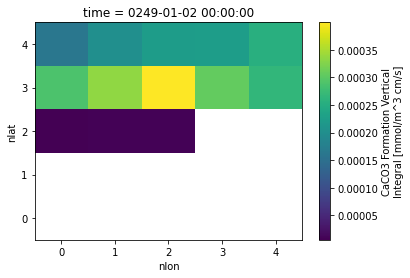

In [24]:
dsets['ocn.pop.h.ecosys.nday1.g.e11_LENS.GECOIAF.T62_g16.009'].CaCO3_form_zint.isel(time=0).plot();

## Conclusion
Having the ability to easily create intake-esm catalogs from history files can be a powerful tool in your analysis toolkit. These data can be read in relatively quickly, easing the ability to quickly take a look at model output or even share your data with others! For more updates on [ecgtools](https://github.com/NCAR/ecgtools), be sure to follow [the ecgtools repository](https://github.com/NCAR/ecgtools) on Github! Have an idea for another helpful parser? Submit an issue!